# Behavioral Cloning - Self-Driving Car ND Project

## Introduction

In this project, a technique called end-to-end learning will be discussed. Using a provided simulator, I'll record driving data according to my behavior behind the wheel, and then I'll train a deep network to mimic my way of driving and learn how to drive in the simulator by itself.

## Data collection

The simulator collects data from three cameras mounted on the windshield of the car (left, center and right cameras). It also records the steering angle associated with each set of images and it records approximately 10 data points (three images plus a steering angle) per second.

Training the network with only regular driving data might not be sufficient, because the network might never learn how to recover from a mistake. One way of improving this issue is to augment the data by using the left and right images and add corrective biases to their associated steering angle (this method was used is this NVIDIA paper: http://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf).

Another method, which was used here, is to collect data while driving somewhat irregularly. Data was recorded with the car drinving on the edges of the track and also going in the reverse direction of the track (to balance the total number of left and right turns).

## Data visualization

In [1]:
### Import necessary packages
import numpy as np
import pandas as pd
import cv2
from os.path import basename, isfile
import pickle
import json
#from sklearn.utils import shuffle
from scipy.signal import gaussian
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
def visualize_dataset(file_name):
    dataset = pd.read_csv(file_name, header=0)
    time = np.linspace(0., dataset.shape[0]/10., num=dataset.shape[0])
    plt.plot(time, dataset['steering'][:])
    return dataset

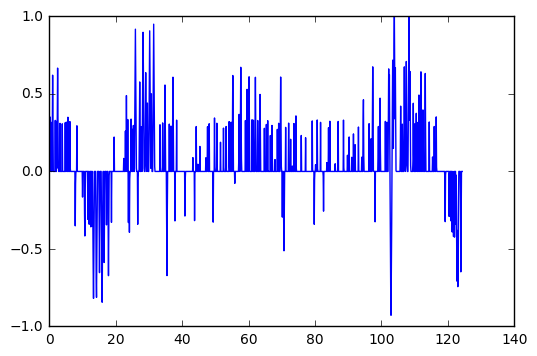

In [3]:
center_rev = visualize_dataset('track1/full_center_rev1/driving_log.csv')

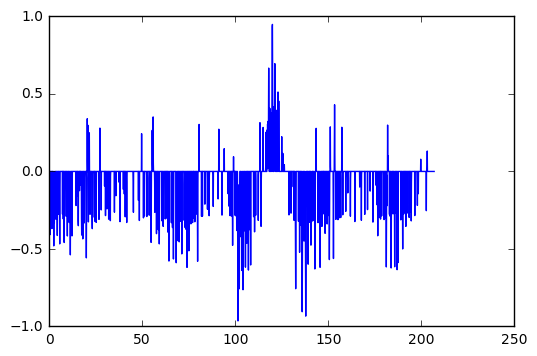

In [10]:
center = visualize_dataset('track1/full_center1/driving_log.csv')

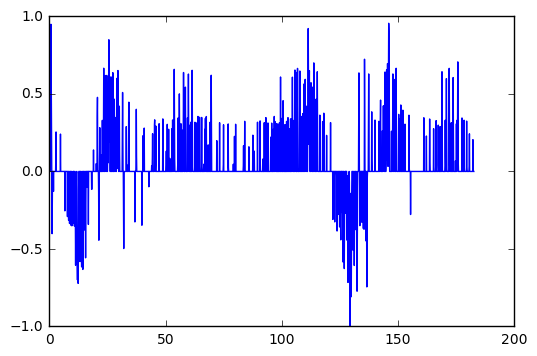

In [5]:
to_left_rev = visualize_dataset('track1/full_toLeft_rev1/driving_log.csv')

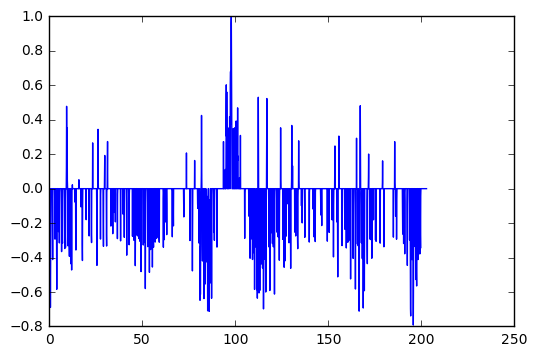

In [6]:
to_left = visualize_dataset('track1/full_toLeft1/driving_log.csv')

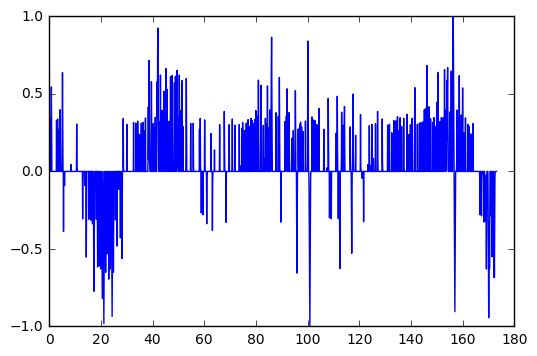

In [7]:
to_right_rev = visualize_dataset('track1/full_toRight_rev1/driving_log.csv')

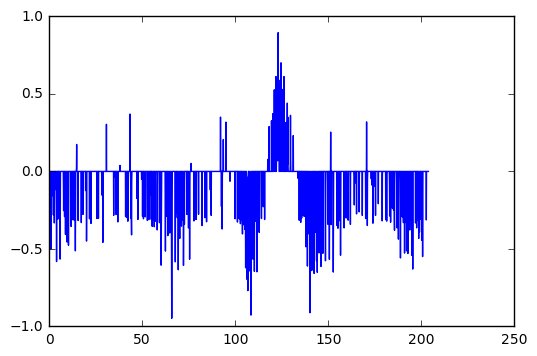

In [8]:
to_right = visualize_dataset('track1/full_toRight1/driving_log.csv')

## Data preparation

In [9]:
def add_bias(dataset, bias=0.):
    #dataset = np.convolve(dataset, gaussian_window, 'same')/5.
    dataset = np.convolve(dataset, gaussian_window, 'same')
    steering_data = dataset + bias
    steering_data = np.append(steering_data, dataset + bias, axis=0)
    steering_data = np.append(steering_data, dataset + bias, axis=0)
    return steering_data

def read_images(dataset):
    img_data = np.empty((dataset.shape[0], 64, 64, 1))
    for i in range(dataset.shape[0]):
        img = cv2.imread('IMG/' + basename(dataset[i]), cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (64, 64), interpolation=cv2.INTER_AREA)
        img_data[i, :, :, :] = img.reshape((64, 64, 1))
    return img_data

def load_from_log(driving_log_df, bias=0.):
    img_data = read_images(driving_log_df['center'])
    img_data = np.append(img_data, read_images(driving_log_df['left']), axis=0)
    img_data = np.append(img_data, read_images(driving_log_df['right']), axis=0)
    steering_data = add_bias(driving_log_df['steering'], bias=bias)
    return img_data, steering_data

def concat_data(dataset_list):
    final_dataset = dataset_list[0]
    for i in range(1, len(dataset_list)):
        final_dataset = np.append(final_dataset, dataset_list[i], axis=0)
    return final_dataset

In [2]:
#pickle_file = 'train_data.pickle'
pickle_file = 'train_data_norm_gauss.pickle'

if isfile(pickle_file):
        print('File already exists.')
        with open(pickle_file, mode='rb') as f:
            train = pickle.load(f)
        img_train = train['img']
        steering_train = train['steering']
else:
    
    #gaussian_window = gaussian(50, std=5.)
    sigma = 3.
    mu = 0.
    x = np.arange(-3*sigma, 3.1*sigma, sigma/16) # Size of window: 12
    gaussian_window = (np.exp((-1.*x**2)/(2*sigma**2)))*(1./(np.sqrt(2*np.pi*sigma**2)))
    gaussian_window = gaussian_window/np.sum(gaussian_window)
    
    c_img, c_steering = load_from_log(center)
    c_rev_img, c_rev_steering = load_from_log(center_rev)

    tL_img, tL_steering = load_from_log(to_left, bias=-0.15)
    tL_rev_img, tL_rev_steering = load_from_log(to_left_rev, bias=-0.15)

    tR_img, tR_steering = load_from_log(to_right, bias=0.15)
    tR_rev_img, tR_rev_steering = load_from_log(to_right_rev, bias=0.15)

    img_train = concat_data([c_img, c_rev_img,
                             tL_img, tL_rev_img,
                             tR_img, tR_rev_img])
    steering_train = concat_data([c_steering, c_rev_steering,
                                 tL_steering, tL_rev_steering,
                                 tR_steering, tR_rev_steering])

print(img_train.shape, steering_train.shape)

File already exists.
(32805, 32, 32, 1) (32805,)


In [11]:
if isfile(pickle_file):
        print('File already exists. Skipping pickling...')
else:
    print('Pickling...')
    try:
        f = open(pickle_file, 'wb')
        save = {
            'img': img_train,
            'steering': steering_train,
        }
        pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
        f.close()
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise

Pickling...


In [15]:
from sklearn.utils import shuffle
### Shuffle the data
img_train, steering_train = shuffle(img_train, steering_train)

In [3]:
### Normalize the image data
img_train = img_train/255. - 0.5

## Network architecture

In [18]:
from keras.models import Sequential
from keras.layers.core import Dense, Flatten, Activation
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

# Fix error with TF and Keras
import tensorflow as tf
tf.python.control_flow_ops = tf

model = Sequential()
model.add(Convolution2D(8, 1, 1, border_mode='valid', input_shape=(32, 32, 1)))
model.add(Activation('relu'))
model.add(Convolution2D(16, 3, 3, border_mode='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(32, 1, 1, border_mode='valid'))
model.add(Activation('relu'))
model.add(Convolution2D(64, 3, 3, border_mode='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(32, 1, 1, border_mode='valid'))
model.add(Activation('relu'))
model.add(Convolution2D(128, 3, 3, border_mode='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dense(1))

## Training and Validation

In [19]:
### Train model to minimize 'mse'
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(img_train, steering_train, nb_epoch=20, validation_split=0.2)

### Save model parameters
model.save_weights('teste_norm.h5')
model_json = model.to_json()
with open('teste_norm.json', 'w') as f:
    json.dump(model_json, f)

Train on 26244 samples, validate on 6561 samples
Epoch 1/20
26244/26244 [==============================] - 82s - loss: 0.0038 - val_loss: 0.0022
Epoch 2/20
26244/26244 [==============================] - 104s - loss: 0.0011 - val_loss: 9.6696e-04
Epoch 3/20
26244/26244 [==============================] - 127s - loss: 6.8637e-04 - val_loss: 6.2621e-04
Epoch 4/20
26244/26244 [==============================] - 137s - loss: 4.7106e-04 - val_loss: 4.5123e-04
Epoch 5/20
26244/26244 [==============================] - 169s - loss: 3.6580e-04 - val_loss: 4.5805e-04
Epoch 6/20
26244/26244 [==============================] - 108s - loss: 3.1329e-04 - val_loss: 3.3203e-04
Epoch 7/20
26244/26244 [==============================] - 106s - loss: 2.5927e-04 - val_loss: 2.1161e-04
Epoch 8/20
26244/26244 [==============================] - 130s - loss: 2.2558e-04 - val_loss: 3.3344e-04
Epoch 9/20
26244/26244 [==============================] - 150s - loss: 2.0909e-04 - val_loss: 1.9202e-04
Epoch 10/20
26244/2

NameError: name 'json' is not defined

In [20]:
import json
with open('teste_norm.json', 'w') as f:
    json.dump(model_json, f)

## Testing on unseen data

In [4]:
from keras.models import model_from_json
import json
# Fix error with TF and Keras
import tensorflow as tf
tf.python.control_flow_ops = tf

with open('teste_norm.json', 'r') as jfile:
        model = model_from_json(json.loads(jfile.read()))

model.compile("adam", "mse")
weights_file = 'teste_norm.h5'
model.load_weights(weights_file)

Using TensorFlow backend.


## Draft code blocks

In [15]:
img_ = img_train[2501, :, :, :]
t_img_ = img_[None, :, :, :]
print(float(model.predict(t_img_, batch_size=1)), steering_train[2501])

0.19697950780391693 0.1


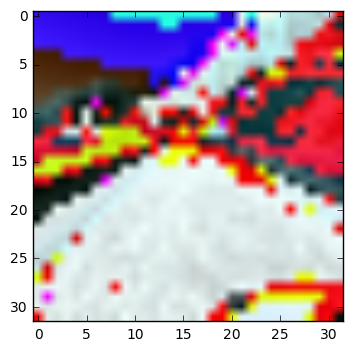

In [16]:
plt.imshow(img_)

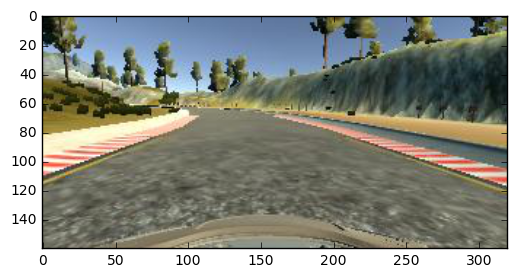

In [14]:
img = cv2.imread('IMG/' + basename(center['center'][0]))
from PIL import Image
img_pil = Image.open('IMG/' + basename(center['center'][0]))
img_pil = np.asarray(img_pil)
plt.imshow(img_pil)

(160, 320, 1)


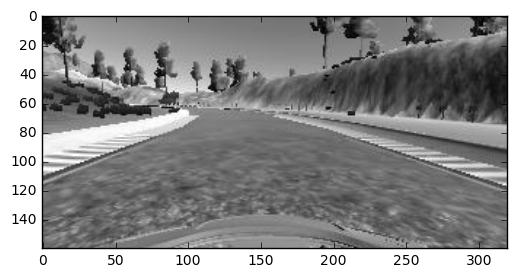

In [36]:
img = cv2.imread('IMG/' + basename(center['center'][0]), cv2.IMREAD_GRAYSCALE)
#img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = img.reshape((160, 320, 1))
print(img.shape)
plt.imshow(img[:, :, 0], cmap='gray')

(64, 64, 1)


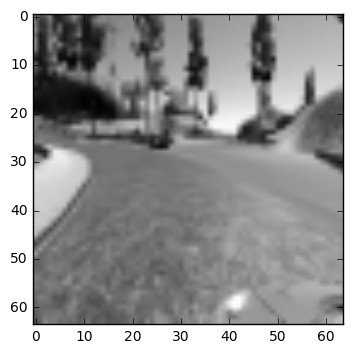

In [35]:
img = cv2.imread('IMG/' + basename(center['left'][1010]))
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img, (64, 64), interpolation=cv2.INTER_AREA)
img = img.reshape((64, 64, 1))
print(img.shape)
plt.imshow(img[:, :, 0], cmap='gray')

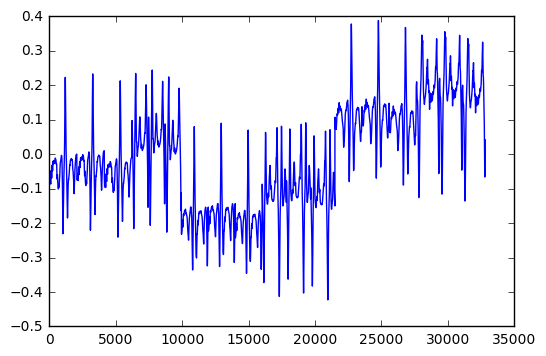

In [12]:
plt.plot(steering_train)

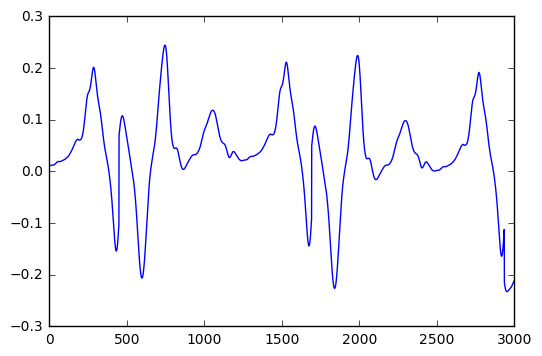

In [13]:
plt.plot(steering_train[7000:10000])

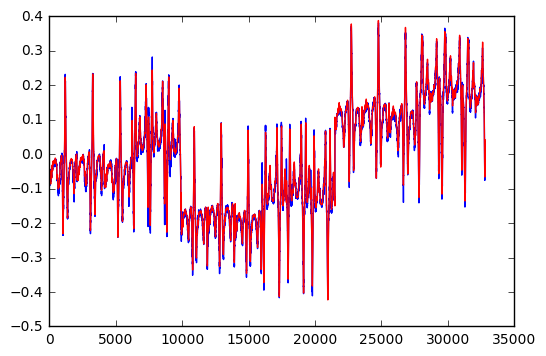

In [7]:
plt.plot(model.predict(img_train[:, :, :, :]), 'b', steering_train[:], 'r')

In [6]:
model.evaluate(img_train, steering_train)

32805/32805 [==============================] - 30s    


8.0294997583293452e-05

5.32158787753


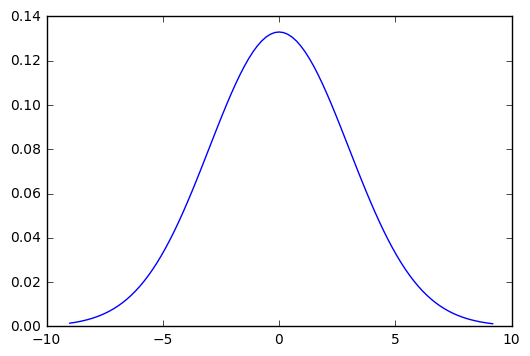

In [41]:
sigma = 3.
mu = 0.
x = np.arange(-3*sigma, 3.1*sigma, sigma/16)
gaussian_ = (np.exp((-1.*x**2)/(2*sigma**2)))*(1./(np.sqrt(2*np.pi*sigma**2)))
plt.plot(x, gaussian_)
print(np.sum(gaussian_))

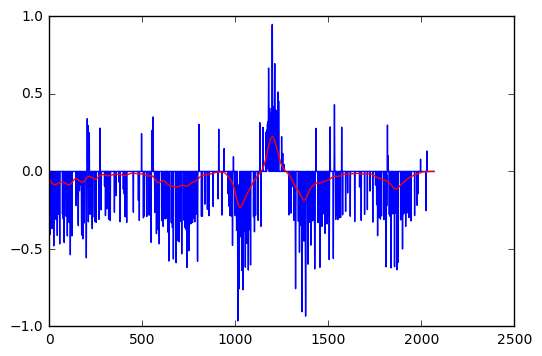

In [42]:
teste = np.convolve(center['steering'], gaussian_/5.32, 'same')
plt.plot(center['steering'], 'b', teste, 'r')

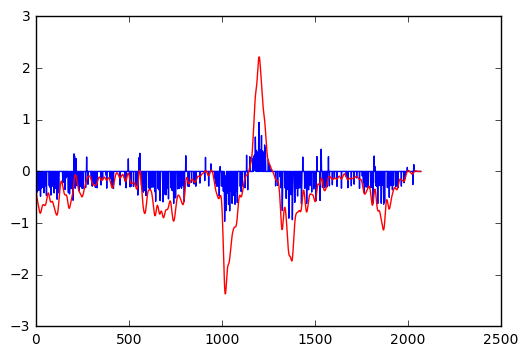

In [26]:
teste = np.convolve(center['steering'], gaussian_, 'same')
plt.plot(center['steering'], 'b', teste, 'r')

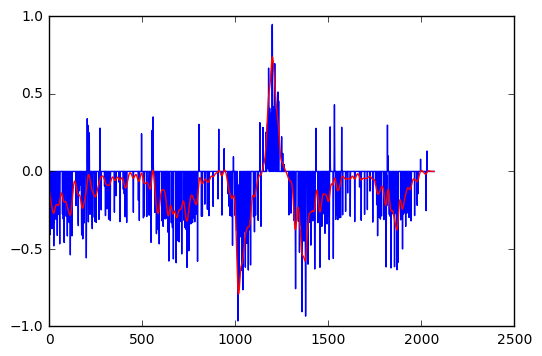

In [32]:
teste = np.convolve(center['steering'], gaussian_, 'same')
plt.plot(center['steering'], 'b', teste, 'r')

In [16]:
print(center_rev['steering'].shape)

(1243,)


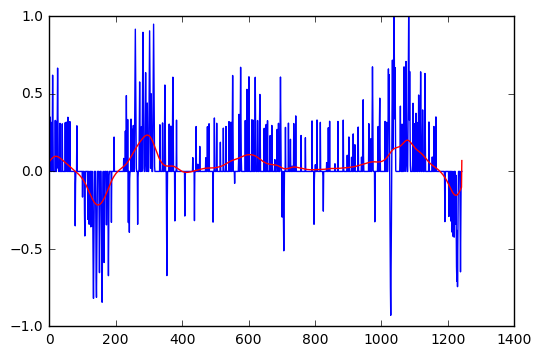

In [17]:
plt.plot(center_rev['steering'], 'b', steering_train[6208:7451], 'r')

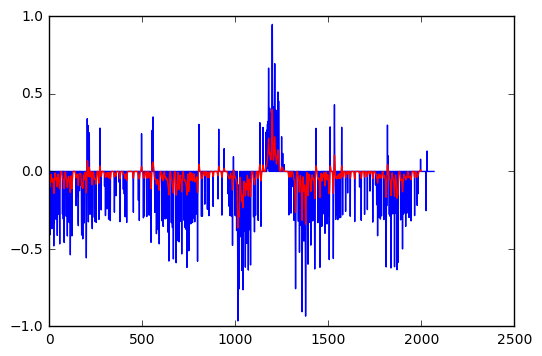

In [16]:
plt.plot(center['steering'], 'b', steering_train[0:2000], 'r')

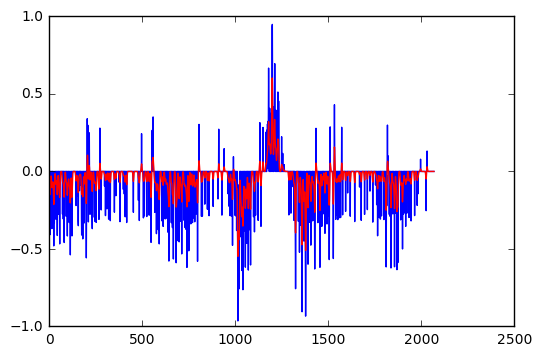

In [23]:
from scipy.ndimage.filters import gaussian_filter1d
plt.plot(center['steering'], 'b', gaussian_filter1d(center['steering'], 3), 'r')

In [23]:
print(np.sum(window)/np.sum(gaussian_))

2.34884438697


In [18]:
#from scipy.signal import gaussian
window = gaussian(30, std=5.)

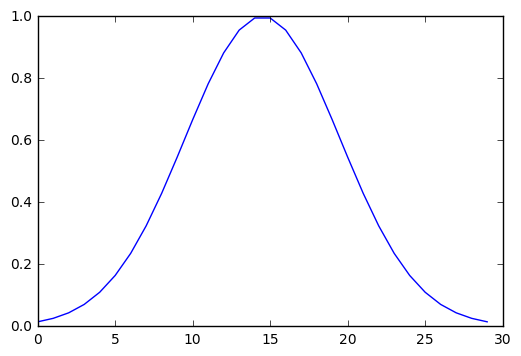

In [19]:
plt.plot(window)

In [100]:
print(np.sum(window))

12.5331344906


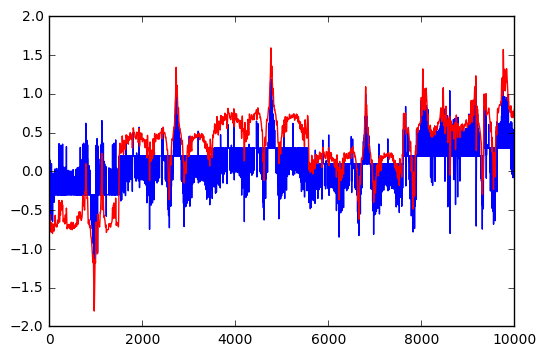

In [118]:
teste = np.convolve(steering_train, window, 'same')
plt.plot(steering_train[20000:30000], 'b', teste[20000:30000]/5., 'r')

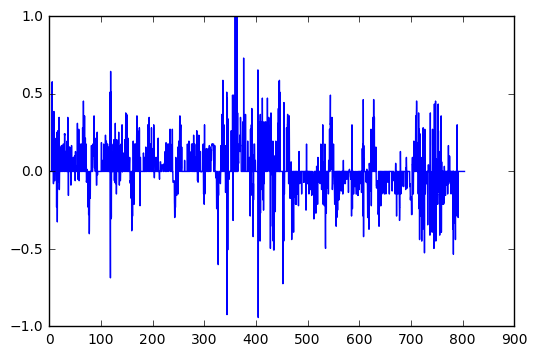

In [97]:
udacity_data = visualize_dataset('udacity_data/driving_log.csv')

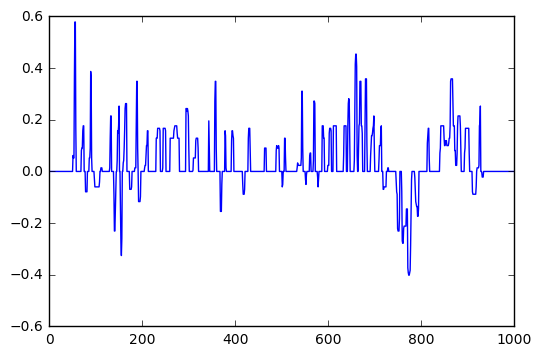

In [99]:
plt.plot(udacity_data['steering'][0:1000])

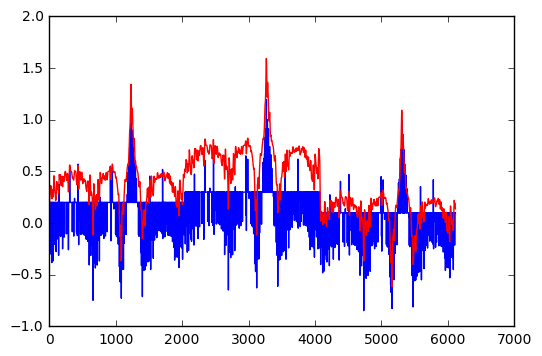

In [126]:
tL = add_bias(to_right['steering'], bias=0.2)
tL_conv = np.convolve(tL, window, 'same')
plt.plot(tL, 'b', tL_conv/5, 'r')

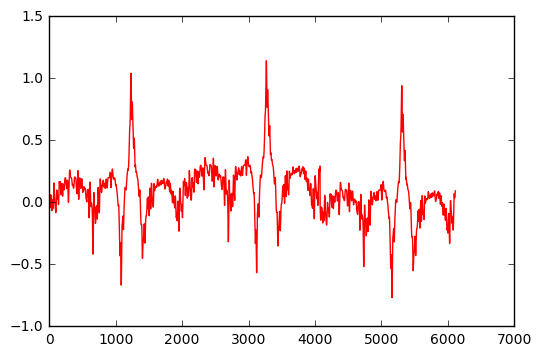

In [128]:
tL = add_bias(to_right['steering'], bias=0.2)
#tL_conv = np.convolve(tL, window, 'same')
plt.plot(tL, 'r')

In [15]:
import time
img = cv2.imread('IMG/' + basename(to_right['center'][100]))
start_time = time.time()
img_t = cv2.resize(img, (32, 32), interpolation=cv2.INTER_AREA)
img_t = img_t/255. - 0.5
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.0005018711090087891 seconds ---


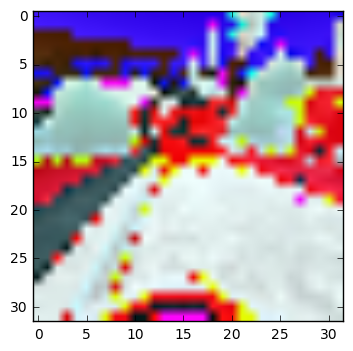

In [16]:
plt.imshow(img_t)

In [7]:
print(np.mean(img_train), np.std(img_train))

0.00871463352844 0.176037968621


In [10]:
import time
start_time = time.time()
model.predict(img_train[0:1, :, :, :])
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.9279794692993164 seconds ---


In [11]:
import time
start_time = time.time()
model.predict(img_train[0:1, :, :, :])
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.32877302169799805 seconds ---
